In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository.

## Get the data
First download and import the dataset using pandas:

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

In [6]:
# The dataset contains a few unknown values.
dataset.isna().sum()
# Drop those rows to keep this initial tutorial simple.
dataset = dataset.dropna()
# The "Origin" column is really categorical, not numeric. So convert that to a one-hot with pd.get_dummies:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into train and test

In [7]:
#Now split the dataset into a training set and a test set.
# Use the test set in the final evaluation of your models.

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

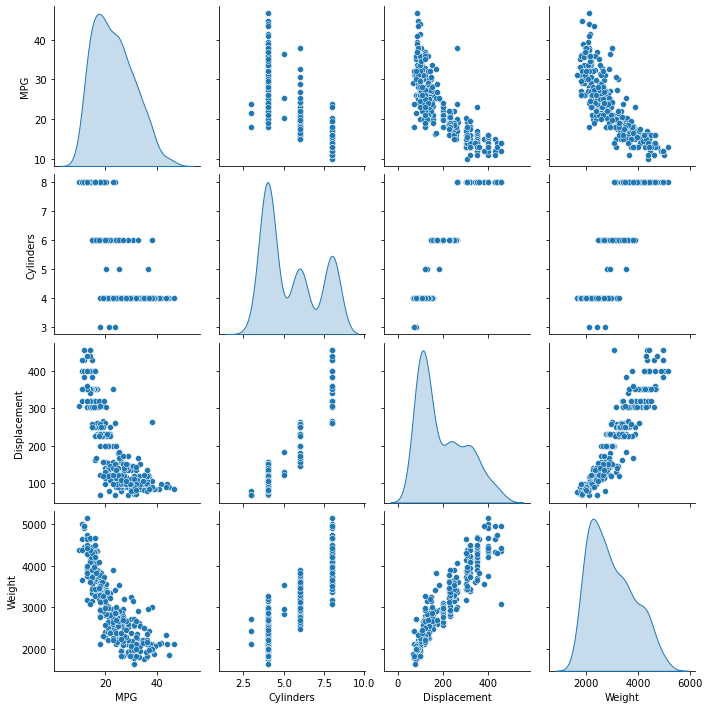

In [8]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [9]:
# Also look at the overall statistics, note how each feature covers a very different range:

train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [10]:
## Split features from labels
## Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.


train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
In the table of statistics it's easy to see how different the ranges of each feature are.

In [11]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


### The Normalization layer
The preprocessing.Normalization layer is a clean and simple way to build that preprocessing into your model.

In [13]:
# The first step is to create the layer:
normalizer = preprocessing.Normalization(axis=-1)

# Then .adapt() it to the data:
normalizer.adapt(np.array(train_features))

# This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

# When the layer is called it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]
First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression
Before building a DNN model, start with a linear regression.

One Variable
Start with a single-variable linear regression, to predict MPG from Horsepower.

Training a model with tf.keras typically starts by defining the model architecture.

In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there are two steps:

Normalize the input horsepower.
Apply a linear transformation () to produce 1 output using layers.Dense.
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First create the horsepower Normalization layer:


In [14]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

## Build the sequential model:

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [15]:
# This model will predict MPG from Horsepower.

# Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, (10,1):

horsepower_model.predict(horsepower[:10])

array([[-0.858],
       [-0.484],
       [ 1.583],
       [-1.202],
       [-1.087],
       [-0.427],
       [-1.288],
       [-1.087],
       [-0.283],
       [-0.484]], dtype=float32)

Once the model is built, configure the training procedure using the Model.compile() method. The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).


In [16]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use Model.fit() to execute the training:

In [20]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1.79 s, sys: 159 ms, total: 1.95 s
Wall time: 1.57 s


In [21]:
# Visualize the model's training progress using the stats stored in the history object.


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,3.806528,4.194067,95
96,3.805748,4.187355,96
97,3.808732,4.198548,97
98,3.806251,4.187265,98
99,3.802849,4.194937,99


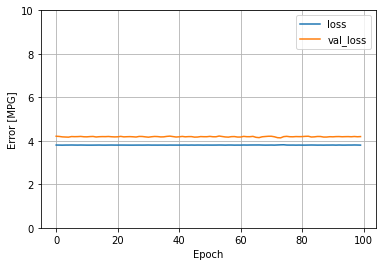

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

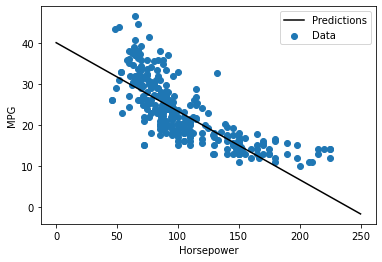

In [24]:
# Collect the results on the test set, for later:


test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

# Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:


x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x,y)

In [25]:
# Multiple inputs
# You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same  except that  is a matrix and  is a vector.

# This time use the Normalization layer that was adapted to the whole dataset.


linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# When you call this model on a batch of inputs, it produces units=1 outputs for each example.


linear_model.predict(train_features[:10])

array([[-0.969],
       [-0.489],
       [ 0.669],
       [-1.777],
       [ 0.069],
       [-1.036],
       [-0.176],
       [ 0.844],
       [-0.718],
       [ 1.084]], dtype=float32)

In [26]:
# When you call the model it's weight matrices will be built. Now you can see that the kernel (the  in ) has a shape of (9,1).


linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.684],
       [-0.11 ],
       [ 0.71 ],
       [ 0.656],
       [ 0.052],
       [-0.262],
       [ 0.522],
       [ 0.585],
       [-0.035]], dtype=float32)>

In [27]:
# Use the same compile and fit calls as for the single input horsepower model:

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [28]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.17 s, sys: 154 ms, total: 2.32 s
Wall time: 1.98 s


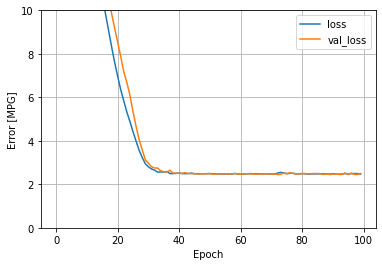

In [29]:
# Using all the inputs achieves a much lower training and validation error than the horsepower model:


plot_loss(history)

In [30]:
# Collect the results on the test set, for later:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## A DNN regression
The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

The normalization layer.
Two hidden, nonlinear, Dense layers using the relu nonlinearity.
A linear single-output layer.
Both will use the same training procedure so the compile method is included in the build_and_compile_model function below.


In [31]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# One variable

# Start with a DNN model for a single input: "Horsepower"
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

# This model has quite a few more trainable parameters than the linear models.
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [32]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.7 s, sys: 641 ms, total: 3.34 s
Wall time: 2.17 s


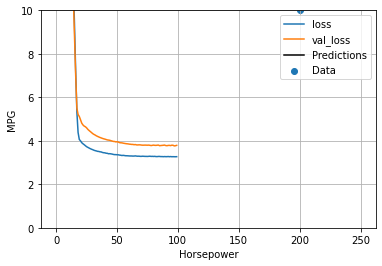

In [33]:
# This model does slightly better than the linear-horsepower model.
plot_loss(history)

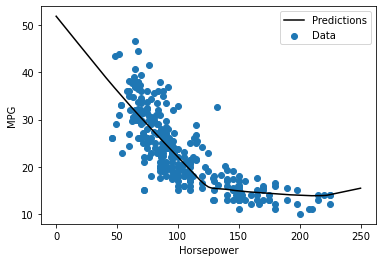

In [34]:
# If you plot the predictions as a function of Horsepower, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [35]:
# Collect the results on the test set, for later:


test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Full model
If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.


In [36]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [37]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.67 s, sys: 590 ms, total: 3.26 s
Wall time: 2.19 s


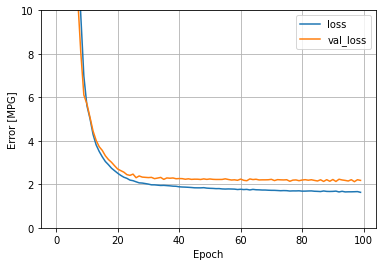

In [38]:
plot_loss(history)

In [39]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance
Now that all the models are trained check the test-set performance and see how they did:

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.652114
linear_model,2.520284
dnn_horsepower_model,2.941939
dnn_model,1.674576


### Make predictions
Finally, predict have a look at the errors made by the model when making predictions on the test set:

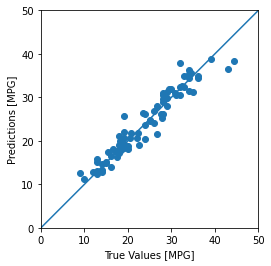

In [41]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


INFO:tensorflow:Assets written to: dnn_model/assets


,Mean absolute error [MPG]
horsepower_model,3.652114
linear_model,2.520284
dnn_horsepower_model,2.941939
dnn_model,1.674576
reloaded,1.674576


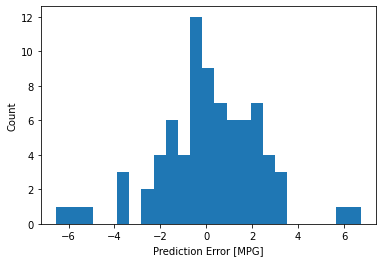

In [43]:
# It looks like the model predicts reasonably well.
# Now take a look at the error distribution:

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


# If you're happy with the model save it for later use:
dnn_model.save('dnn_model')

# INFO:tensorflow:Assets written to: dnn_model/assets
# If you reload the model, it gives identical output:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

In [44]:
dnn_model.save('dnn_model')

# INFO:tensorflow:Assets written to: dnn_model/assets
# If you reload the model, it gives identical output:


reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

INFO:tensorflow:Assets written to: dnn_model/assets


,Mean absolute error [MPG]
horsepower_model,3.652114
linear_model,2.520284
dnn_horsepower_model,2.941939
dnn_model,1.674576
reloaded,1.674576
